In [72]:
#Imports

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(tf.__version__)


2.6.0


My First Visual Studio Code, Tensorflow, & Jupyter Notebook Project

Code copied from https://www.kaggle.com/ryanholbrook/custom-convnets

In [99]:
# Load training and validation sets

# Load full cars 196 training set labels.
test_mat = scipy.io.loadmat('./Annos/cars_test_annos.mat')
train_mat = scipy.io.loadmat('./Annos/cars_train_annos.mat')
cars_meta = scipy.io.loadmat('./Annos/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)


print("Processing train data...")
cars_annos = scipy.io.loadmat('./Annos/cars_train_annos.mat')
annotations = cars_annos['annotations']

annotations = np.transpose(annotations)



fnames = []
class_ids = []
bboxes = []
labels = []

for annotation in annotations:
    bbox_x1 = annotation[0][0][0][0]
    bbox_y1 = annotation[0][1][0][0]
    bbox_x2 = annotation[0][2][0][0]
    bbox_y2 = annotation[0][3][0][0]
    class_id = annotation[0][4][0][0]
    labels.append('%04d' % (class_id,))
    fname = annotation[0][5][0]
    bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
    class_ids.append(class_id)
    fnames.append(fname)


print(bboxes)
#print(np.unique(labels))
#print('The number of different cars is %d' % labels_count)


Processing train data...
[(39, 116, 569, 375), (36, 116, 868, 587), (85, 109, 601, 381), (621, 393, 1484, 1096), (14, 36, 133, 99), (259, 289, 515, 416), (88, 80, 541, 397), (73, 79, 591, 410), (20, 126, 1269, 771), (21, 110, 623, 367), (51, 93, 601, 393), (6, 62, 499, 286), (30, 36, 418, 307), (31, 246, 778, 540), (32, 77, 589, 379), (27, 49, 611, 396), (39, 52, 233, 150), (3, 8, 190, 147), (247, 287, 1366, 761), (17, 281, 961, 596), (17, 156, 695, 375), (212, 538, 1893, 1131), (11, 28, 476, 234), (53, 126, 973, 621), (34, 87, 567, 343), (30, 174, 598, 379), (80, 107, 606, 336), (45, 115, 585, 382), (28, 139, 1564, 1126), (82, 109, 874, 521), (55, 318, 446, 564), (12, 31, 471, 350), (34, 197, 1011, 656), (37, 63, 614, 397), (223, 87, 1111, 670), (138, 41, 521, 223), (31, 87, 616, 344), (16, 89, 459, 326), (53, 113, 614, 350), (214, 110, 660, 403), (61, 55, 566, 408), (28, 61, 622, 371), (22, 39, 588, 362), (220, 193, 537, 364), (12, 108, 489, 297), (28, 80, 759, 466), (84, 248, 1102, 

In [17]:

# Reproducability
# Setup the random seed so training data is feed in the same each run.
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
# The plotting layout presets.
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')


# Create a tensorflow datasta (tf.data.Dataset).  Matches the images with the binary label "Car" or "Truck".  All the images are 128x128 and if they need to be resized use nearsest neighbor interpolation.    Shuffle the training set.  Do not shuffle the validation set.  It doesn't matter the order of the validation no need to shuffle. 
ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/train',
    labels='inferred',
    #Changed from binary to categorical_crossentropy because of the expanded labels.
    label_mode='categorical_crossentropy',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/valid',
    labels='inferred',
    #Changed from binary to categorical_crossentropy because of the expanded labels.
    label_mode='categorical_crossentropy',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
# Process the images into pixel arrays so matrix operations can be preformed on them.  
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

# Putting it all together.  Take the training dataset which is sized and labeled.  Convert to pixel array.  Cache in memory for faster runtime.  Autotune sets up the CPU so it's fetching the next image in the list while the current image is in the CNN.  
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



Found 2000 files belonging to 2 classes.
Found 1909 files belonging to 2 classes.


Load Pretrained Base

In [6]:
#VGG16 pretrained base for baseline.

pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[128,128,3],
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
pretrained_base.trainable = False

Early Stopping

In [7]:
# Stop early if the accucary is not improving enough.

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Attach Head

In [8]:




# Pretrained base model

# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])

# Custom base  0.8051346 val_binary_accuracy

model = keras.Sequential([

    # First Convolutional Block
    # 32 filter layers, Kernel Size of 5 x 5. Relu activation.  Add zeroes all around so the image doesn't change size, Padding='same'.
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    #Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    # Classifier Head.  Fully connected Dense layer with 6 nodes and a relu activation.  Final node for binary decision. 
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

Train

In [9]:
#Compile.  Use the Adam optimizer which uses stochastic gradient descent to adjust weights.  Binary_crossentropy since it's either 'car' or 'truck.

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Fit the Model. 
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[early_stopping], 
    verbose=1,
)

2021-10-12 12:50:10.545171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
32/32 [==============================] - 42s 1s/step - loss: 0.6854 - binary_accuracy: 0.5610 - val_loss: 0.6693 - val_binary_accuracy: 0.6061
Epoch 2/50
32/32 [==============================] - 42s 1s/step - loss: 0.6529 - binary_accuracy: 0.6030 - val_loss: 0.6543 - val_binary_accuracy: 0.6244
Epoch 3/50
32/32 [==============================] - 43s 1s/step - loss: 0.6230 - binary_accuracy: 0.6460 - val_loss: 0.6442 - val_binary_accuracy: 0.6045
Epoch 4/50
32/32 [==============================] - 46s 1s/step - loss: 0.5678 - binary_accuracy: 0.7085 - val_loss: 0.6638 - val_binary_accuracy: 0.5872
Epoch 5/50
32/32 [==============================] - 41s 1s/step - loss: 0.5607 - binary_accuracy: 0.7025 - val_loss: 0.5887 - val_binary_accuracy: 0.6815
Epoch 6/50
32/32 [==============================] - 41s 1s/step - loss: 0.5157 - binary_accuracy: 0.7435 - val_loss: 0.5593 - val_binary_accuracy: 0.7103
Epoch 7/50
32/32 [==============================] - 41s 1s/step - loss: 0.47

KeyboardInterrupt: 

0     0.606076
1     0.624411
2     0.604505
3     0.587218
4     0.681509
5     0.710320
6     0.728654
7     0.741750
8     0.762179
9     0.774751
10    0.797276
11    0.776323
12    0.805134
13    0.790990
14    0.740178
15    0.782085
16    0.779466
17    0.762703
Name: val_binary_accuracy, dtype: float64


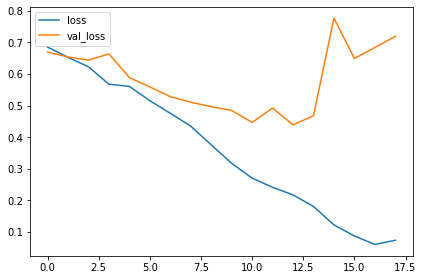

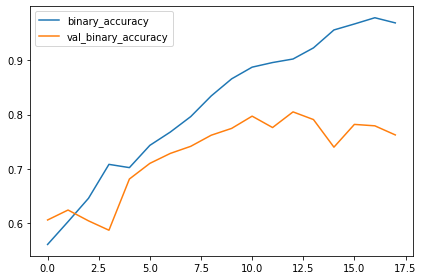

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print(history_frame.val_binary_accuracy)
